In [40]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 9.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=dc572569584fd4f96737fe6d9aba4ec39dfcf50ec2e2d798acb27b5bda4db36d
  Stored in directory: /Users/lieselvranckx/Library/Caches/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import selectivesearch

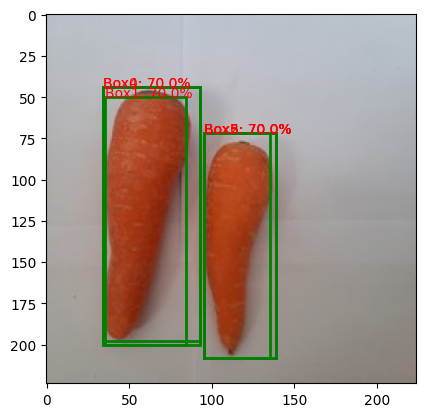

In [84]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch

image_path = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Carrot/1023.jpg'

# Load the image with correct color channels
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Draw an empty figure
fig, ax = plt.subplots()

# Plot the image
ax.imshow(image)

# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.99, min_size=10)
min_box_size = 1000

# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.30
aspect_ratio_range = 0.35

selected_boxes = []
for region in selective_search_results[1]:
    x, y, w, h = region['rect']
    if w * h >= min_box_size:
        aspect_ratio = float(w) / h
        if abs(aspect_ratio - target_aspect_ratio) <= aspect_ratio_range:
            selected_boxes.append((x, y, x + w, y + h))

rect = []
for i, (x, y, x2, y2) in enumerate(selected_boxes):
    rect.append(patches.Rectangle((x, y), x2 - x, y2 - y, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='red')

# Show the figure
plt.show()


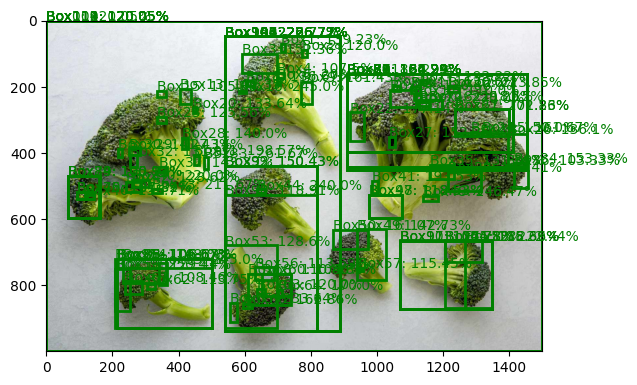

In [45]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch

image_path = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train/brocolis.jpeg'
# Load the image with correct color channels
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Draw an empty figure
fig, ax = plt.subplots()
# Plot the image
ax.imshow(image)

selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.9, min_size=100)

objectness_score_threshold = 0.9
minimum_bounding_box_size = 100
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.30
aspect_ratio_range = 0.30

selected_candidates = []
for candidate in selective_search_results[1]:
    x, y, w, h = candidate['rect']

    # Calculate bounding box size and aspect ratio
    bounding_box_size = w * h
    aspect_ratio = max(w / h, h / w)

    # Check objectness score, bounding box size, and aspect ratio
    if (
        bounding_box_size >= minimum_bounding_box_size
        and aspect_ratio <= maximum_aspect_ratio
        and (aspect_ratio - target_aspect_ratio) * 100 > 100
    ):
        selected_candidates.append(candidate)

rect = []
for i, candidate in enumerate(selected_candidates):
    x, y, w, h = candidate['rect']
    rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    aspect_ratio = max(w / h, h / w)
    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')

# Show the figure
plt.show()

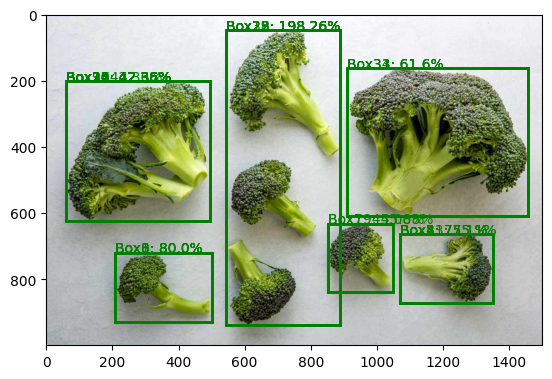

In [132]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch

image_path = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train/brocolis.jpeg'

# Load the image
image = cv2.imread(image_path)

# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.8, min_size=100)

minimum_bounding_box_size = 80
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.6
aspect_ratio_range = 0.6

selected_candidates = []
for candidate in selective_search_results[1]:
    x, y, w, h = candidate['rect']

    # Calculate bounding box size and aspect ratio
    bounding_box_size = w * h
    aspect_ratio = max(w / h, h / w)

    # Exclude the bounding box of the whole picture
    image_size = image.shape[0] * image.shape[1]
    box_coverage = bounding_box_size / image_size
    if box_coverage < 0.98 and bounding_box_size >= minimum_bounding_box_size and aspect_ratio <= maximum_aspect_ratio:
        selected_candidates.append({'rect': (x, y, w, h), 'index': i})


# Function to calculate the coverage ratio between two bounding boxes
def calculate_coverage_ratio(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = min(x1 + w1, x2 + w2) - intersection_x
    intersection_h = min(y1 + h1, y2 + h2) - intersection_y

    intersection_area = max(0, intersection_w) * max(0, intersection_h)
    box1_area = w1 * h1
    box2_area = w2 * h2

    return intersection_area / box1_area, box1_area, box2_area

# List to store the filtered bounding boxes
filtered_boxes = []

# Iterate through the selected bounding boxes
for i in range(len(selected_candidates)):
    current_box = selected_candidates[i]['rect']
    is_contained = False
    smol = False

    # Check if the coverage ratio of the current box is less than 90% of any other box
    for j in range(len(selected_candidates)):
        if i != j:
            other_box = selected_candidates[j]['rect']
            coverage_ratio, current_area, other_area = calculate_coverage_ratio(current_box, other_box)
            if coverage_ratio >= 0.5 and current_area < other_area:
                # The current box is contained within another box
                smol = True
                break
    # If the current box is not contained, add it to the filtered list
    if not smol:
        filtered_boxes.append(current_box)


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

rect = []
for i, box in enumerate(filtered_boxes):
    x, y, w, h = box
    rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    aspect_ratio = max(w / h, h / w)
    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')

# Show the figure
plt.show()

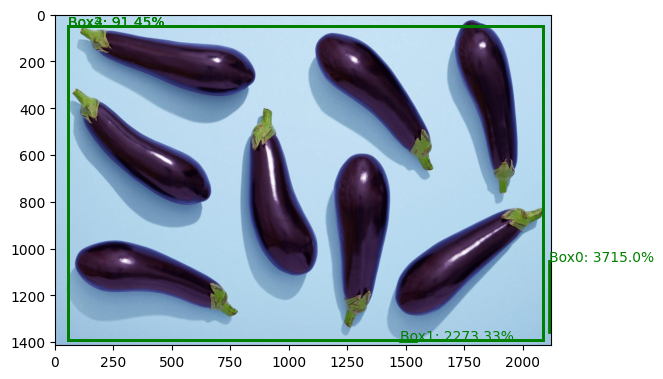

In [135]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch

image_path = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train/eggplants.jpeg'

# Load the image
image = cv2.imread(image_path)

# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.8, min_size=100)

minimum_bounding_box_size = 80
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.6
aspect_ratio_range = 0.6

selected_candidates = []
for candidate in selective_search_results[1]:
    x, y, w, h = candidate['rect']

    # Calculate bounding box size and aspect ratio
    bounding_box_size = w * h
    aspect_ratio = max(w / h, h / w)

    # Exclude the bounding box of the whole picture
    image_size = image.shape[0] * image.shape[1]
    box_coverage = bounding_box_size / image_size
    if box_coverage < 0.98 and bounding_box_size >= minimum_bounding_box_size and aspect_ratio <= maximum_aspect_ratio:
        selected_candidates.append({'rect': (x, y, w, h), 'index': i})


# Function to calculate the coverage ratio between two bounding boxes
def calculate_coverage_ratio(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = min(x1 + w1, x2 + w2) - intersection_x
    intersection_h = min(y1 + h1, y2 + h2) - intersection_y

    intersection_area = max(0, intersection_w) * max(0, intersection_h)
    box1_area = w1 * h1
    box2_area = w2 * h2

    return intersection_area / box1_area, box1_area, box2_area

# List to store the filtered bounding boxes
filtered_boxes = []

# Iterate through the selected bounding boxes
for i in range(len(selected_candidates)):
    current_box = selected_candidates[i]['rect']
    is_contained = False
    smol = False

    # Check if the coverage ratio of the current box is less than 90% of any other box
    for j in range(len(selected_candidates)):
        if i != j:
            other_box = selected_candidates[j]['rect']
            coverage_ratio, current_area, other_area = calculate_coverage_ratio(current_box, other_box)
            if coverage_ratio >= 0.5 and current_area < other_area:
                # The current box is contained within another box
                smol = True
                break
    # If the current box is not contained, add it to the filtered list
    if not smol:
        filtered_boxes.append(current_box)


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

rect = []
for i, box in enumerate(filtered_boxes):
    x, y, w, h = box
    rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    aspect_ratio = max(w / h, h / w)
    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')

# Show the figure
plt.show()

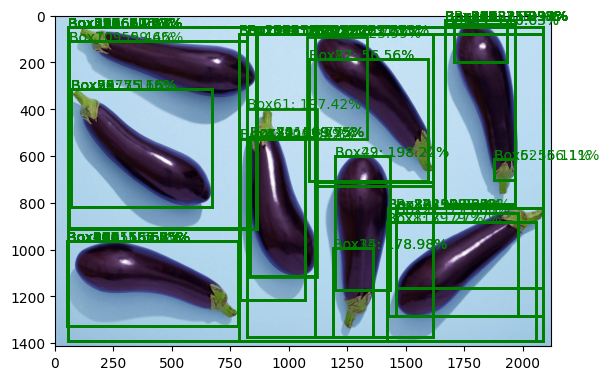

In [108]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch

image_path = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train/eggplants.jpeg'

# Load the image
image = cv2.imread(image_path)

# Perform selective search to generate candidate regions
selective_search_results = selectivesearch.selective_search(image, scale=750, sigma=0.95, min_size=100)

minimum_bounding_box_size = 100
maximum_aspect_ratio = 3
# Calculate target aspect ratio range (adjust as per your requirement)
target_aspect_ratio = 0.45
aspect_ratio_range = 0.30

selected_candidates = []
for candidate in selective_search_results[1]:
    x, y, w, h = candidate['rect']

    # Calculate bounding box size and aspect ratio
    bounding_box_size = w * h
    aspect_ratio = max(w / h, h / w)

    # Exclude the bounding box of the whole picture
    image_size = image.shape[0] * image.shape[1]
    box_coverage = bounding_box_size / image_size
    if box_coverage < 0.98 and bounding_box_size >= minimum_bounding_box_size and aspect_ratio <= maximum_aspect_ratio:
        selected_candidates.append({'rect': (x, y, w, h), 'index': i})


# Function to calculate the coverage ratio between two bounding boxes
def calculate_coverage_ratio(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = min(x1 + w1, x2 + w2) - intersection_x
    intersection_h = min(y1 + h1, y2 + h2) - intersection_y

    intersection_area = max(0, intersection_w) * max(0, intersection_h)
    box1_area = w1 * h1
    box2_area = w2 * h2

    return intersection_area / box1_area, box1_area, box2_area

# List to store the filtered bounding boxes
filtered_boxes = []

# Iterate through the selected bounding boxes
for i in range(len(selected_candidates)):
    current_box = selected_candidates[i]['rect']
    is_contained = False

    # Check if the coverage ratio of the current box is less than 90% of any other box
    for j in range(len(selected_candidates)):
        if i != j:
            other_box = selected_candidates[j]['rect']
            coverage_ratio, current_area, other_area = calculate_coverage_ratio(current_box, other_box)
            if coverage_ratio >= 0.99:
                # The current box is contained within another box
                is_contained = True
                if current_area >= other_area:
                    filtered_boxes.append(current_box)
                else:
                    break
    # If the current box is not contained, add it to the filtered list
    if not is_contained:
        filtered_boxes.append(current_box)


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

rect = []
for i, box in enumerate(filtered_boxes):
    x, y, w, h = box
    rect.append(patches.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))
    ax.add_patch(rect[i])

    aspect_ratio = max(w / h, h / w)
    ax.text(x, y, f'Box{i}: {round((aspect_ratio - target_aspect_ratio) * 100, 2)}%', color='green')

# Show the figure
plt.show()
